# Part 2: 
#### Measuring an impact of influencers reviews on businesses: studying how (positive 5 stars) reviews of influencers effect on an average rating and frequency of other user`s reviews 

##### Importing libraries...

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import pymongo
import pprint
from pymongo import MongoClient
import datetime as dt
from operator import attrgetter
%matplotlib inline


##### Creating a data base connection...

In [2]:
client = MongoClient('mongodb://localhost:27017')
db = client.yelp
con_check = str(db)
if con_check.find('yelp') != int(-1):
    print('...Connected')
else:
    print('...Connection Failed')

...Connected


##### Reading influencers list file...


In [3]:
top_df = pd.read_json('intermediate_datasets\influencers.json')
top_df = top_df.sort_values(['count_friends'], ascending=False) # Sorting influencers by the number of friends
top_df = top_df.sort_values(['fans'], ascending=False) # Sorting influencers by the number of fans
top_df.head(2)


# not sorting by the number of elite years as in this case the sorting gives contoversial results 

,_id,count_elite,count_friends,fans
2.0,spJUPXI7QaIctU0FO5c42w,7,2789,1363
25.0,7uxXuCcpw9-mUS3OJVw8aQ,11,1751,1339


##### Choosing an influencer from the list...

In [4]:
influencer = top_df._id[(top_df.index[1])] # Picking a particular influencer from the list index[]
influencer_reviews = list(db.review.find({"user_id":influencer})) # fetching all reviews done by this influencer from the data base
influencer

'7uxXuCcpw9-mUS3OJVw8aQ'

##### Choosing a particular business...

In [5]:
 # Creating a data frame for influenccer reviews
#----------------------------------------------------------------------------------------------------------------------------
infl_reviews_df = pd.DataFrame(influencer_reviews)
infl_reviews_df = infl_reviews_df.sort_values('date', ascending=True)    
# sorting influencers reviews to have the earliest reviews of the most positive reviews on the top of the list
# ensuring the first positive influencer`s review of businesses
infl_reviews_df = infl_reviews_df.sort_values('stars', ascending=False)
#----------------------------------------------------------------------------------------------------------------------------

infl_reviews_df.head(2)

,_id,business_id,date,review_id,stars,text,type,user_id,votes
6,57712c097b99e7221559d5c6,Q4ULAiIE2qCA4RYplCTrUQ,2006-08-04,y1Y5A0QBEE-k4IYxNCA7YA,5,I'd driven up to Pittsburgh with some friends ...,review,7uxXuCcpw9-mUS3OJVw8aQ,"{'cool': 12, 'funny': 14, 'useful': 8}"
10,57712c197b99e722155afc01,sAbRiVqmxNdjTja_vmnsnA,2008-05-02,e8vONwAG15WO6TS0Uuo7Gw,5,My bf often tells me to just leave off the mak...,review,7uxXuCcpw9-mUS3OJVw8aQ,"{'cool': 17, 'funny': 12, 'useful': 16}"


In [6]:
# Picking business_id of the first review in influencer`s reviews data frame
infl_business_id = infl_reviews_df.business_id[(infl_reviews_df.index[0])]
# Fetching all reviews of the chosen business from the data base
infl_business_reviews = list(db.review.find({"business_id":infl_business_id}))


In [7]:
infl_business_reviews_df = pd.DataFrame(infl_business_reviews)# Creating data frame of all reviews of a chosen business
infl_business_reviews_df.tail(2)


,_id,business_id,date,review_id,stars,text,type,user_id,votes
736,57712c097b99e7221559d8a0,Q4ULAiIE2qCA4RYplCTrUQ,2015-12-16,eRkTLKRK5efHoNf2p0OG_A,5,I love cabbage and french fries on my sandwich...,review,tw8hi3SKq5DGj8XeSqOibg,"{'cool': 0, 'funny': 0, 'useful': 0}"
737,57712c097b99e7221559d8a1,Q4ULAiIE2qCA4RYplCTrUQ,2015-12-21,iYmqJPttGH2i82jhCOiveQ,4,"The sandwiches are legen, wait for it dary. Al...",review,4L9I4PyxB0gqo-nOjUBdPQ,"{'cool': 0, 'funny': 0, 'useful': 0}"


##### Plotting reviews stars vs dates...

In [8]:
dates = list(infl_business_reviews_df.date) # Creating a list of dates of all reviews a business has
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates] # Changing dates type to datetime type
y = list(infl_business_reviews_df.stars) # Creating a list of reviews rating


In [9]:
# Finding the date of influencer`s first top rated review for
infl_review_date = infl_business_reviews_df[(infl_business_reviews_df.user_id == influencer)].date 

# Changing influencer`s review date to string type
datex = list(infl_review_date)
infl_review_date = datex[0]

infl_review_date

'2006-08-04'

In [10]:
# Creating a data frame with reviews before influencer`s review 
before_review_df = infl_business_reviews_df[infl_business_reviews_df.date <= infl_review_date]


In [11]:
#-------------------------------------------------------------------------------------------------------------------------------
# Calculating average rating before the influencer`s review
stars_sum = 0
for stars in before_review_df.stars:
    stars_sum = stars + stars_sum
reviews_count = before_review_df.stars.count()
avg_stars = stars_sum/reviews_count
#-------------------------------------------------------------------------------------------------------------------------------

before_dates_from_df = list(before_review_df.date) # Getting all dates before an influencer`s review date
before_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in before_dates_from_df] # Converting dates type to datetime type
# Calculating the differnece in days between the date of the first review and the date when an influencer has made a review
days_before_1st_review = abs((before_dates[-1] - before_dates[0]).days) # Number of days from first review up to the treshold
weeks_before_1st_review = days_before_1st_review/7 
months_before_1s_review = weeks_before_1st_review/4

print('Average stars of the business before:',avg_stars)
print('Daily reviews frequiency before:', reviews_count/days_before_1st_review)
print('Weekly reviews frequiency before:', reviews_count/weeks_before_1st_review)
print('Monthly reviews frequiency before:', reviews_count/months_before_1s_review)
print('Number of reviews before:', reviews_count)


Average stars of the business before: 5.0
Daily reviews frequiency before: 0.0909090909091
Weekly reviews frequiency before: 0.636363636364
Monthly reviews frequiency before: 2.54545454545
Number of reviews before: 7


In [12]:
# Creating a data frame with reviews after an influencer`s review 
after_review_df = infl_business_reviews_df[infl_business_reviews_df.date > infl_review_date]

In [13]:
#-------------------------------------------------------------------------------------------------------------------------------
# Calculating average rating after an influencer`s review
stars_sum = 0
for stars in after_review_df.stars:
    stars_sum = stars + stars_sum
reviews_count = after_review_df.stars.count()
avg_stars = stars_sum/reviews_count
#-------------------------------------------------------------------------------------------------------------------------------
after_dates_from_df = list(after_review_df.date) # Getting all dates after an influencer`s review date
after_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in after_dates_from_df] # Converting dates type to datetime type
# Calculating the differnece in days between the date of the the last review and the date when an influencer has made a review
days_after_1st_review = abs((after_dates[-1] - after_dates[0]).days) # Number of days from the treshold up to the last review
weeks_after_1st_review = days_after_1st_review/7
months_after_1s_review = weeks_after_1st_review/4

print('Average stars of the business after:',avg_stars)
print('Daily reviews frequiency after:', reviews_count/days_after_1st_review)
print('Weekly reviews frequiency after:', reviews_count/weeks_after_1st_review)
print('Monthly reviews frequiency after:', reviews_count/months_after_1s_review)
print('Number of reviews after:', reviews_count)



Average stars of the business after: 3.50068399453
Daily reviews frequiency after: 0.21840454138
Weekly reviews frequiency after: 1.52883178966
Monthly reviews frequiency after: 6.11532715865
Number of reviews after: 731


In [14]:
weeks= list()
wcount = min(x) # x is a list of a business reviews dates 

weekly_reviews_list = list()
weekly_stars_avg_list = list()

while wcount <= max(x):
    weeks.append(wcount)
    wcount = wcount + dt.timedelta(7)

for week in weeks:
    weekly_review_count = 0.0
    weekly_stars_sum = 0.0
    weekly_stars_avg = 0.0
    date_index = 0

    for date in infl_business_reviews_df.date :
        date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        
        if date >= week and date <= week + dt.timedelta(6):
            weekly_review_count = 1 + weekly_review_count
            weekly_stars_sum = weekly_stars_sum + infl_business_reviews_df.stars[date_index]
            weekly_stars_avg = weekly_stars_sum / weekly_review_count

        date_index = date_index + 1
        
    weekly_reviews_list.append(weekly_review_count)
    weekly_stars_avg_list.append(weekly_stars_avg)


In [15]:
months= list()
mcount = min(x) # x is a list of a business reviews dates 

monthly_reviews_list = list()
monthly_stars_avg_list = list()

while mcount <= max(x):
    months.append(mcount)
    mcount = mcount + 4 * dt.timedelta(7)

for month in months:
    monthly_review_count = 0.0
    monthly_stars_sum = 0.0
    monthly_stars_avg = 0.0
    date_index = 0

    for date in infl_business_reviews_df.date :
        date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        
        if date >= month and date <= month + 4 * dt.timedelta(6):
            monthly_review_count = 1 + monthly_review_count
            monthly_stars_sum = monthly_stars_sum + infl_business_reviews_df.stars[date_index]
            monthly_stars_avg = monthly_stars_sum / monthly_review_count

        date_index = date_index + 1
        
    monthly_reviews_list.append(monthly_review_count)
    monthly_stars_avg_list.append(monthly_stars_avg)


In [16]:
other_reviews_dates = list()
other_reviews_stars = list()
date_index = 0
for user in infl_business_reviews_df.user_id:
    
    for other_influencer in top_df._id:
        if other_influencer == user:
            other_reviews_dates.append(infl_business_reviews_df.date[date_index])
            other_reviews_stars.append(infl_business_reviews_df.stars[date_index])
    
    date_index = 1 + date_index
other_reviews_dates
other_influencers_reviews_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in other_reviews_dates]


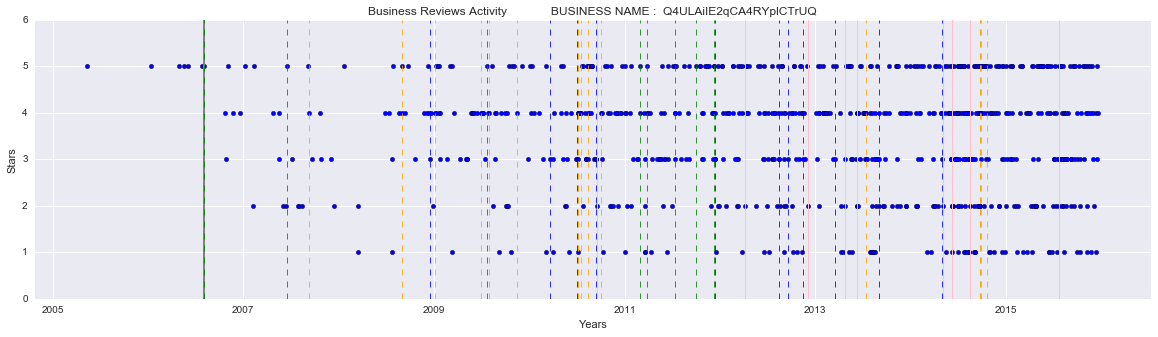

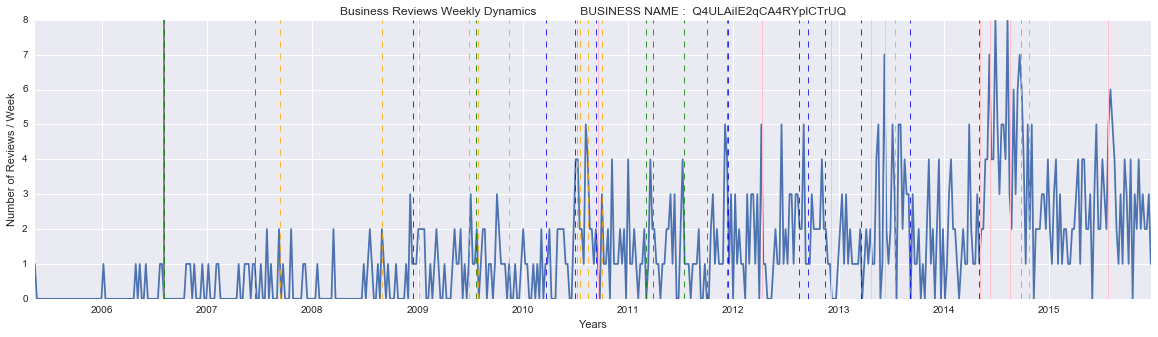

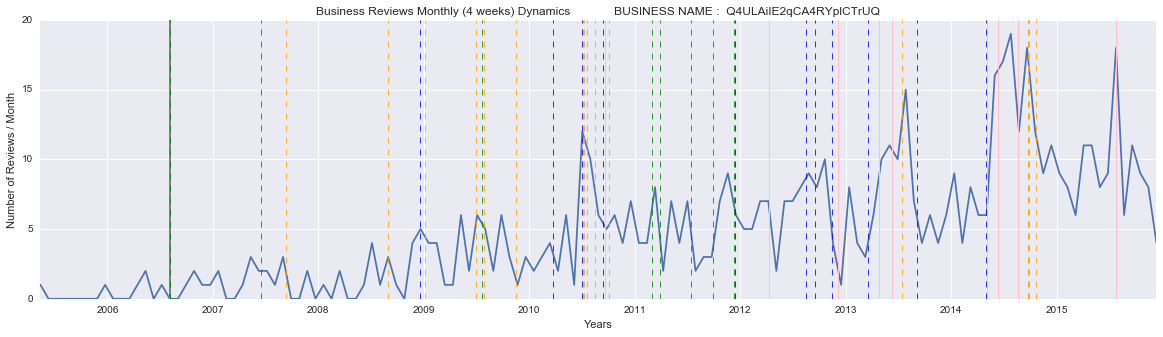

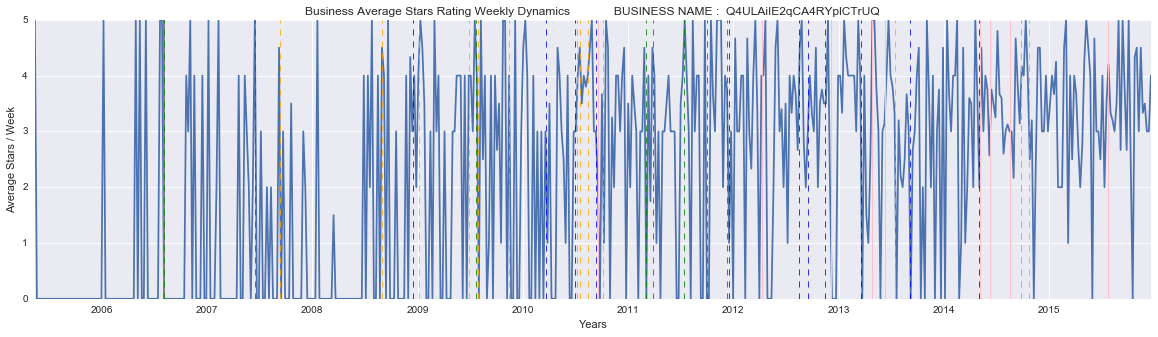

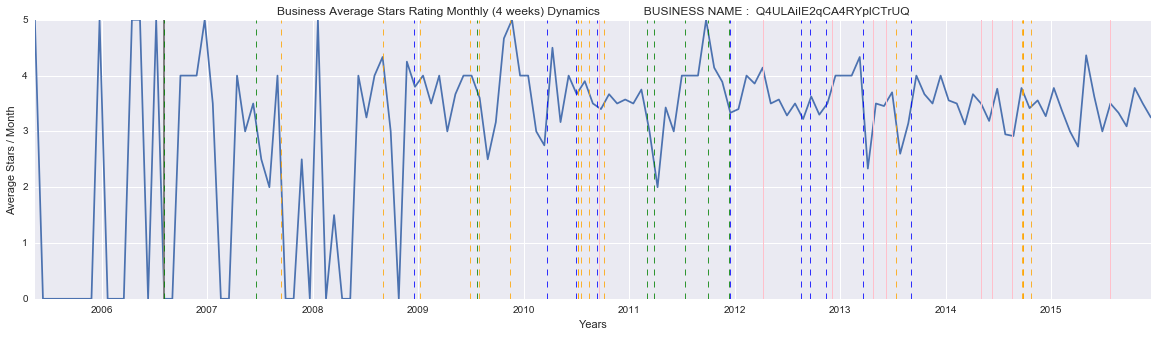

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(x, y,alpha=1)
ax.set_title('Business Reviews Activity' + '             BUSINESS NAME :  ' + infl_business_id)
ax.set_xlabel('Years')
ax.set_ylabel('Stars')
ax.axvline(pd.to_datetime(infl_review_date) , color='grey', linestyle='-', lw=2) 
stars_index = 0
for date in other_influencers_reviews_dates :
    stars = other_reviews_stars[stars_index]
    if stars == 5:
        plt.axvline(date , color='green', linestyle='--', lw=0.8)
    elif stars == 4:
        plt.axvline(date , color='orange', linestyle='--', lw=0.8)
    elif stars == 3:
        plt.axvline(date , color='blue', linestyle='--', lw=0.8)
    elif stars == 2:
        plt.axvline(date , color='pink', linestyle='-', lw= 1)
    elif stars == 1:
        plt.axvline(date , color='red', linestyle='-', lw= 1)
    elif stars == 0:   
        plt.axvline(date , color='purple', linestyle='-', lw= 1)
    stars_index = stars_index + 1 

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(weeks, weekly_reviews_list,alpha=1)
ax.set_title('Business Reviews Weekly Dynamics' + '             BUSINESS NAME :  ' + infl_business_id)
ax.set_xlabel('Years')
ax.set_ylabel('Number of Reviews / Week')
ax.axvline(pd.to_datetime(infl_review_date) , color='grey', linestyle='-', lw=2) # Red treshold line = date of influencer`s review
stars_index = 0
for date in other_influencers_reviews_dates :
    stars = other_reviews_stars[stars_index]
    if stars == 5:
        plt.axvline(date , color='green', linestyle='--', lw=0.8)
    elif stars == 4:
        plt.axvline(date , color='orange', linestyle='--', lw=0.8)
    elif stars == 3:
        plt.axvline(date , color='blue', linestyle='--', lw=0.8)
    elif stars == 2:
        plt.axvline(date , color='pink', linestyle='-', lw= 1)
    elif stars == 1:
        plt.axvline(date , color='red', linestyle='-', lw= 1)
    elif stars == 0:   
        plt.axvline(date , color='purple', linestyle='-', lw= 1)
    stars_index = stars_index + 1 

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(months, monthly_reviews_list,alpha=1)
ax.set_title('Business Reviews Monthly (4 weeks) Dynamics' + '             BUSINESS NAME :  ' + infl_business_id)
ax.set_xlabel('Years')
ax.set_ylabel('Number of Reviews / Month')
ax.axvline(pd.to_datetime(infl_review_date) , color='grey', linestyle='-', lw=2) # Red treshold line = date of influencer`s review
stars_index = 0
for date in other_influencers_reviews_dates :
    stars = other_reviews_stars[stars_index]
    if stars == 5:
        plt.axvline(date , color='green', linestyle='--', lw=0.8)
    elif stars == 4:
        plt.axvline(date , color='orange', linestyle='--', lw=0.8)
    elif stars == 3:
        plt.axvline(date , color='blue', linestyle='--', lw=0.8)
    elif stars == 2:
        plt.axvline(date , color='pink', linestyle='-', lw= 1)
    elif stars == 1:
        plt.axvline(date , color='red', linestyle='-', lw= 1)
    elif stars == 0:   
        plt.axvline(date , color='purple', linestyle='-', lw= 1)
    stars_index = stars_index + 1 

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(weeks, weekly_stars_avg_list,alpha=1)
ax.set_title('Business Average Stars Rating Weekly Dynamics' + '             BUSINESS NAME :  ' + infl_business_id)
ax.set_xlabel('Years')
ax.set_ylabel('Average Stars / Week')
ax.axvline(pd.to_datetime(infl_review_date) , color='grey', linestyle='-', lw=2) # Red treshold line = date of influencer`s review
stars_index = 0
for date in other_influencers_reviews_dates :
    stars = other_reviews_stars[stars_index]
    if stars == 5:
        plt.axvline(date , color='green', linestyle='--', lw=0.8)
    elif stars == 4:
        plt.axvline(date , color='orange', linestyle='--', lw=0.8)
    elif stars == 3:
        plt.axvline(date , color='blue', linestyle='--', lw=0.8)
    elif stars == 2:
        plt.axvline(date , color='pink', linestyle='-', lw= 1)
    elif stars == 1:
        plt.axvline(date , color='red', linestyle='-', lw= 1)
    elif stars == 0:   
        plt.axvline(date , color='purple', linestyle='-', lw= 1)
    stars_index = stars_index + 1 

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(months, monthly_stars_avg_list,alpha=1)
ax.set_title('Business Average Stars Rating Monthly (4 weeks) Dynamics' + '             BUSINESS NAME :  ' + infl_business_id)
ax.set_xlabel('Years')
ax.set_ylabel('Average Stars / Month')
ax.axvline(pd.to_datetime(infl_review_date) , color='grey', linestyle='-', lw=2) # Red treshold line = date of influencer`s review
stars_index = 0
for date in other_influencers_reviews_dates :
    stars = other_reviews_stars[stars_index]
    if stars == 5:
        plt.axvline(date , color='green', linestyle='--', lw=0.8)
    elif stars == 4:
        plt.axvline(date , color='orange', linestyle='--', lw=0.8)
    elif stars == 3:
        plt.axvline(date , color='blue', linestyle='--', lw=0.8)
    elif stars == 2:
        plt.axvline(date , color='pink', linestyle='-', lw= 1)
    elif stars == 1:
        plt.axvline(date , color='red', linestyle='-', lw= 1)
    elif stars == 0:   
        plt.axvline(date , color='purple', linestyle='-', lw= 1)
    stars_index = stars_index + 1 